In [1]:
%cd ..

/Users/Matteo/PycharmProjects/TrafficEmu


In [30]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [62]:
plt.rcParams['figure.figsize'] = (16.0, 10.0)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.edgecolor'] = 'white'


plt.rcParams['font.size'] = 27
plt.rcParams['axes.labelsize'] = 27
plt.rcParams['xtick.labelsize'] = 27
plt.rcParams['ytick.labelsize'] = 27

In [29]:
import pickle
import numpy as np
import emukit as ek
import GPy
import pandas as pd
import matplotlib.pyplot as plty

from emukit.model_wrappers import GPyModelWrapper
from emukit.core.initial_designs import RandomDesign
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop

from sumo_grid_simulation.grid_simulation import Simulator

In [5]:
simulator = Simulator(end_time=300)

In [6]:
def user_function_timeLoss(X):
    """  X = inputs - emukit doesnt pass named args, just an NxM ndarray, N is the number of points to evaluate, M is the number of parameters per each point """
    result = []
    i = 0
    
    for gridSize, edgeMaxSpeed, edgeLength, numLanes, accel in X:
        
        beta = 0.05
        max_number_of_vehicles = ((gridSize - 1) * gridSize * 2 + 4 * gridSize) * edgeLength / 5
        period = 300/(max_number_of_vehicles * beta)
        
        s = simulator.simulate(
            junctionType  = 1,
            tlType        = 2, 
            gridSize      = int(gridSize),
            edgeMaxSpeed  = edgeMaxSpeed,
            edgeLength    = edgeLength,
            numberOfLanes = int(numLanes),
            accel         = accel,
            trips_generator_period = period
        )
       
        result.append(s['timeLoss']/s['duration'])

    
        i += 1
        
    
    return result  

In [7]:
def user_function_emissions(X):
    """  X = inputs - emukit doesnt pass named args, just an NxM ndarray, N is the number of points to evaluate, M is the number of parameters per each point """
    result = []
    i = 0
    
    for gridSize, edgeMaxSpeed, edgeLength, numLanes, accel in X:
        
        beta = 0.05
        max_number_of_vehicles = ((gridSize - 1) * gridSize * 2 + 4 * gridSize) * edgeLength / 5
        period = 300/(max_number_of_vehicles * beta)
        
        s = simulator.simulate(
            junctionType  = 2,
            tlType        = 2, 
            gridSize      = int(gridSize),
            edgeMaxSpeed  = edgeMaxSpeed,
            edgeLength    = edgeLength,
            numberOfLanes = int(numLanes),
            accel         = accel,
            trips_generator_period = period
        )
       
        result.append(s['CO2'] / (max_number_of_vehicles * beta * s['duration']))
    
        i += 1
        
    
    return result  

In [8]:
results_timeLoss = pickle.load(open('bayesian_optimization/bayesian_opt_results/results_integrated_variance_timeLoss.pkl', 'rb'))
results_co2 = pickle.load(open('bayesian_optimization/bayesian_opt_results/results_400_BO_loops_500_integrated_variance_CO2_ARD.pkl', 'rb'))

In [9]:
parameters_name = ['Size of the grid', 'Speed limit in the net (m/s)', 'Length of the roads (m)', 'Number of lanes', 'Accelleration (m/s^2)']

In [10]:
results_timeLoss_df = pd.DataFrame(results_timeLoss.minimum_location.reshape(1,-1))
results_timeLoss_df.columns = parameters_name
results_timeLoss_df

,Size of the grid,Speed limit in the net (m/s),Length of the roads (m),Number of lanes,Accelleration (m/s^2)
0,10.0,8.0,70.0,2.0,1.862688


In [11]:
results_timeLoss_df.iloc[0][1]

8.0

In [12]:
results_emissions_df = pd.DataFrame(results_co2.minimum_location.reshape(1,-1))
results_emissions_df.columns = parameters_name
results_emissions_df

,Size of the grid,Speed limit in the net (m/s),Length of the roads (m),Number of lanes,Accelleration (m/s^2)
0,20.0,8.0,61.368174,1.0,2.692604


In [13]:
optimal_point = np.array([np.mean([results_timeLoss_df.iloc[0][1], results_emissions_df.iloc[0][1]]),
                          np.mean([results_timeLoss_df.iloc[0][2], results_emissions_df.iloc[0][2]]), 
                          int(np.mean([results_timeLoss_df.iloc[0][3], results_emissions_df.iloc[0][3]])), 
                          np.mean([results_timeLoss_df.iloc[0][4], results_emissions_df.iloc[0][4]])]).reshape(1,-1)
optimal_point

array([[ 8.        , 65.68408723,  1.        ,  2.27764566]])

In [19]:
timeLosses = []
emissions = []


for gridSize in range(9, 21):
    X = np.hstack([np.array([gridSize]).reshape(1,-1), optimal_point])
    y_time = user_function_timeLoss(X)
    y_emissions = user_function_emissions(X)
    
    timeLosses.append(y_time * 100)
    emissions.append(y_emissions)
    

 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds


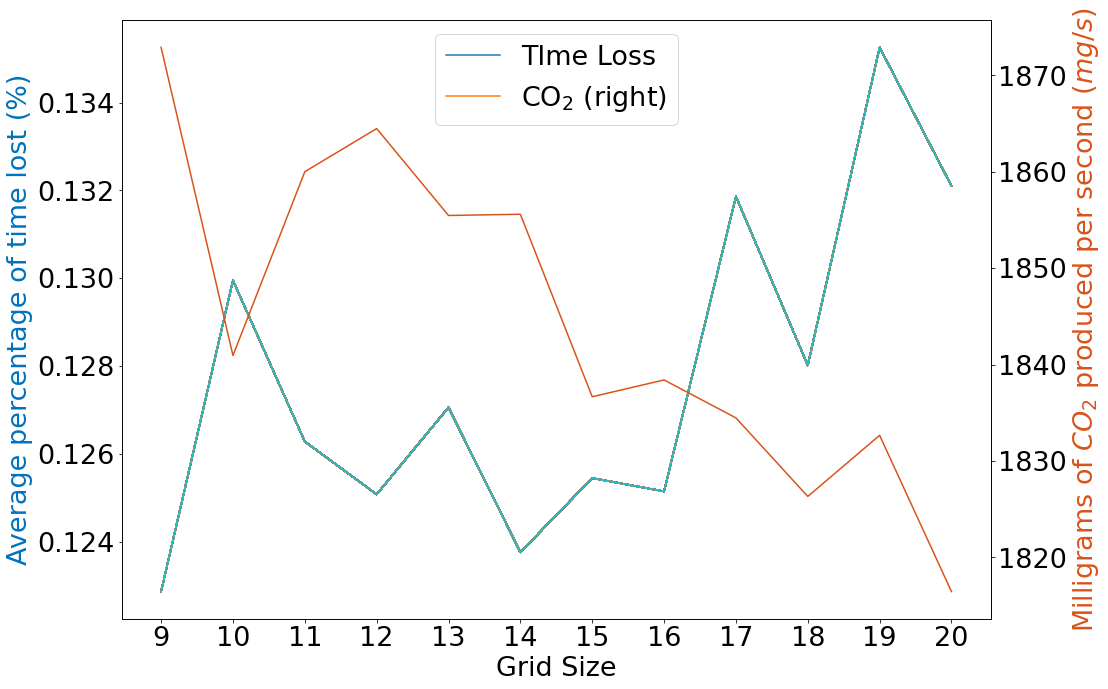

In [63]:
fig, ax = plt.subplots()

blue = [0, 0.4470, 0.7410]
orange = [0.8500, 0.3250, 0.0980]

ax.plot(np.arange(9,21,1), timeLosses)
ax.set_ylabel('Average percentage of time lost (%)', color=blue) 

ax2 = ax.twinx() 
ax2.plot(np.arange(9,21,1), emissions, color=orange)
ax2.set_ylabel('Milligrams of $CO_2$ produced per second ($mg/s$)', color=orange) 

ax.set_xlabel('Grid Size')
#ax.set_title('Trade-off between timeLoss and emissions in the optimal point')
ax.legend(['TIme Loss','CO$_2$ (right)'], loc='upper center')
plt.xticks(np.arange(9,21,1))
fig.tight_layout()  


fig.savefig('bayesian_optimization/trade-off_simulator_gridSize.pdf')